<a href="https://colab.research.google.com/github/DiegoJarquin/Tensorflow/blob/master/Lab5RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Activation, LSTM, Dropout, Conv1D, MaxPooling1D, GRU

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [47]:
from google.colab import files
files.upload()

{}

In [0]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/bittlingmayer/amazonreviews/download" -O data.zip
!unzip data.zip

In [0]:
import bz2

train_file = bz2.BZ2File('AmazonReviews/train.ft.txt.bz2')
test_file = bz2.BZ2File('AmazonReviews/test.ft.txt.bz2')

In [0]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [0]:
sent_analysis = []
def sent_list(docs,splitStr='__label__'):
    for i in range(1,len(docs)):
        text=str(train_file_lines[i])
        splitText=text.split(splitStr)
        #print(i)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        sent_analysis.append([text,sentiment])
    return sent_analysis
sentiment_list=sent_list(train_file_lines[:1000000],splitStr='__label__')


In [51]:
train_df = pd.DataFrame(sentiment_list,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,The best soundtrack ever to anything.: I'm rea...,2
1,Amazing!: This soundtrack is my favorite music...,2
2,Excellent Soundtrack: I truly like this soundt...,2
3,"Remember, Pull Your Jaw Off The Floor After He...",2
4,an absolute masterpiece: I am quite sure any o...,2


In [0]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

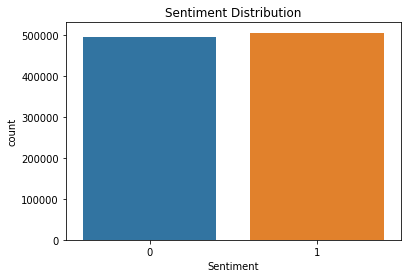

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.axes()
sns.countplot(train_df.Sentiment,ax=ax)
ax.set_title('Sentiment Distribution')
plt.show()

In [54]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,word_count
0,The best soundtrack ever to anything.: I'm rea...,1,97
1,Amazing!: This soundtrack is my favorite music...,1,129
2,Excellent Soundtrack: I truly like this soundt...,1,118
3,"Remember, Pull Your Jaw Off The Floor After He...",1,87
4,an absolute masterpiece: I am quite sure any o...,1,142


In [0]:
reviews = train_df.Text.values


In [0]:
import string 
def punctuation_remove(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)

In [0]:
train_df['Text'] = train_df['Text'].apply(punctuation_remove)


In [58]:
train_df.head()

,Text,Sentiment,word_count
0,The best soundtrack ever to anything Im readin...,1,97
1,Amazing This soundtrack is my favorite music o...,1,129
2,Excellent Soundtrack I truly like this soundtr...,1,118
3,Remember Pull Your Jaw Off The Floor After Hea...,1,87
4,an absolute masterpiece I am quite sure any of...,1,142


In [0]:
train_df1 = train_df[:][train_df['word_count']<=25]


In [60]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1)
c_vector.fit(train_df1['Text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=1, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words) 

In [0]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [0]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [0]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

In [0]:
from gensim.models import word2vec
wv_model = word2vec.Word2Vec(sen_list,size=50)

In [66]:
wv_model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(14350, 50)

In [0]:
def AvgSen(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X_avg = np.zeros([len(sen_list),50])
    c=0
    for sen in sen_list:
        temp = np.zeros([50,])
        nw=0
        for w in sen:
            if w in word_set:
                nw=nw+1
                temp = temp + wv_model[w]
        X_avg[c] = temp/nw
        c=c+1
    return X_avg

In [68]:
X_avg = AvgSen(sen_list,wv_model)
X_avg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


array([[-0.48784816, -0.3344023 ,  0.0555601 , ..., -0.12011566,
        -0.23879968, -0.10457322],
       [ 0.38906376, -0.42922386, -0.14390635, ...,  0.16068221,
        -0.38083762,  0.00558811],
       [-0.31295865, -0.15373596, -0.30842873, ..., -0.38512398,
        -0.31300701, -0.07433113],
       ...,
       [-0.09590402,  0.11102417, -0.32365731, ..., -0.45390082,
         0.01695429,  0.32480502],
       [-0.36053929, -0.18251138, -0.27952664, ..., -0.47123744,
        -0.05467005,  0.14390328],
       [-0.98345141, -0.91469646, -0.44096331, ..., -0.31559157,
         0.0383005 ,  0.06264174]])

In [0]:
def fun(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X = np.zeros([len(sen_list),25,50])
    c = 0
    for sen in sen_list:
        nw=0
        for w in sen:
            if w in word_set:
                X[c,nw] = wv_model[w]
                nw=nw+1
        c=c+1
    return X

In [70]:
X = fun(sen_list,wv_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [0]:
from sklearn.model_selection import train_test_split
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [81]:
model=Sequential()
model.add(LSTM(100,input_shape=(25,50),activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


def train(m, x_t=X_train, y_t=y_train):
  return m.fit(
            x_t,y_t,validation_split=0.1, epochs=5, batch_size=64,verbose=1
          )
  

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
#history = model.fit(X_train,y_train,validation_split=0.1,epochs=6,batch_size=64,verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 65,501
Trainable params: 65,501
Non-trainable params: 0
_________________________________________________________________


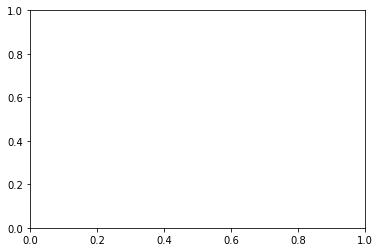

In [82]:
def plot_accuracy_and_loss(history, acc_ylim=[min(plt.ylim()),1.0], loss_ylim=[0,2.0]):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim(acc_ylim)
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim(loss_ylim)
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [83]:
history = train(model)
plot_accuracy_and_loss(history)

ValueError: ignored